# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

# Import Library

In [185]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mplleaflet

# Get Data

In [186]:
def get_data():
    df = pd.read_csv('data/C2A2_data/BinSize_d400.csv')
    hashid = 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89'
    df_by_hash = df[df['hash']==hashid]
    df = df[['ID','NAME']]
    new_df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
    new_df['Data_Value'] =new_df['Data_Value']/10
    df = pd.merge(df,new_df,how='inner')
    return df

# Clear and separate dataframe

I separate dataframe into 2 df:
 - df10year include average min & max temperature by day of 24 place in 10 year (2005-2014)
 - df2015 is df describe average min & max temperature by day of 24 place in 2015

In [187]:
df = get_data()
dfMin = df[df['Element']=='TMIN']
dfMax = df[df['Element']=='TMAX']


def sort_data_by_datatime(df,FuncSort):
    df=df.groupby(['Date'], as_index=False).agg({'Data_Value':FuncSort})
    temp = pd.DatetimeIndex(df['Date'])
    df['Year'],df['Month'],df['Day'] = temp.year,temp.month,temp.day
    tmp = df[(df['Month']==2)&(df['Day']==29)]   # Remove leap day
    df=df.drop('Date',axis = 1).drop(tmp.index)
    return df
dfMin = sort_data_by_datatime(dfMin,'min')
dfMax = sort_data_by_datatime(dfMax,'max')


dfMin2015=dfMin[dfMin['Year']==2015].drop('Year',axis = 1)
dfMax2015=dfMax[dfMax['Year']==2015].drop('Year',axis = 1)

dfMin = dfMin.drop(dfMin2015.index)
dfMax = dfMax.drop(dfMax2015.index)


In [188]:
dfMin = dfMin.groupby(['Month', 'Day'], as_index=False).agg({'Data_Value':'min'})
dfMax = dfMax.groupby(['Month', 'Day'], as_index=False).agg({'Data_Value':'max'})

df10year = pd.merge(dfMin,dfMax,how='inner',on=['Month','Day']).set_index(['Month','Day'])
df10year.rename(columns = {'Data_Value_x':'Min temp C','Data_Value_y':'Max temp C'},inplace = True)

df2015 = pd.merge(dfMin2015,dfMax2015,how='inner',on=['Month','Day']).set_index(['Month','Day'])
df2015.rename(columns = {'Data_Value_x':'Min temp 2015 C','Data_Value_y':'Max temp 2015 C'},inplace = True)

# Plot

In [189]:
new_df = pd.merge(df2015.reset_index(),df10year.reset_index(),how='inner',on = ['Month','Day'])

dfMx = new_df[new_df['Max temp 2015 C']>new_df["Max temp C"]]
dfMn = new_df[new_df['Min temp 2015 C']<new_df["Min temp C"]]

dfMx.index +=1 
dfMn.index +=1

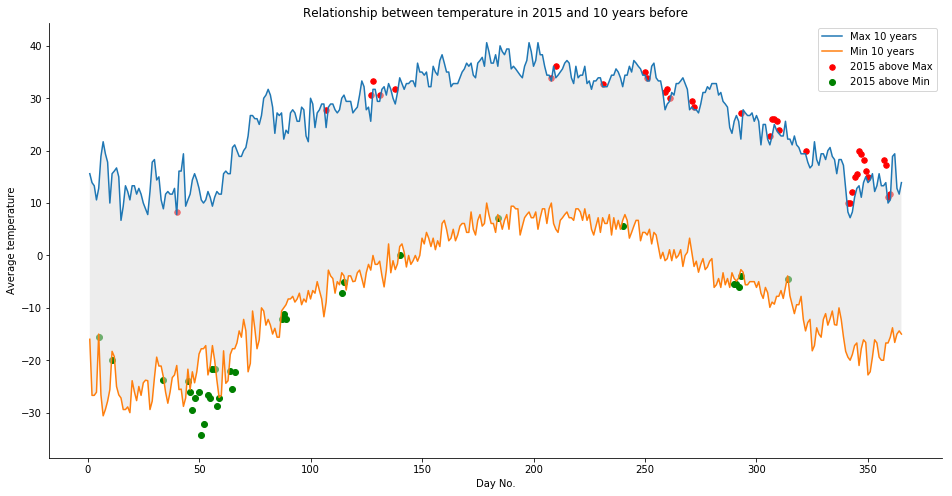

In [190]:
a = range(1,366) # set day in year from 1 to 365
df10 =df10year
df10 = df10.reset_index()
df10.index = np.arange(1, len(df10) + 1)

plt.figure(figsize=(16,8))
plt.plot(df10['Max temp C'],'-',df10['Min temp C'],'-')
plt.scatter(dfMx.index,dfMx['Max temp 2015 C'],c='red',s=30)
plt.scatter(dfMn.index,dfMn['Min temp 2015 C'],c='green')
plt.fill_between(a,df10['Min temp C'],df10['Max temp C'],facecolor = 'gainsboro',alpha = .5)
plt.xlabel('Day No.')
plt.ylabel('Average temperature')
plt.title('Relationship between temperature in 2015 and 10 years before')
plt.legend(['Max 10 years','Min 10 years','2015 above Max','2015 above Min'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [191]:
new_df['Avg 10 year'] = (new_df['Min temp C']+new_df['Max temp C'])/2
new_df['Avg 2015'] = (new_df['Min temp 2015 C']+new_df['Max temp 2015 C'])/2
new_df = new_df[['Month','Day','Avg 10 year','Avg 2015']]

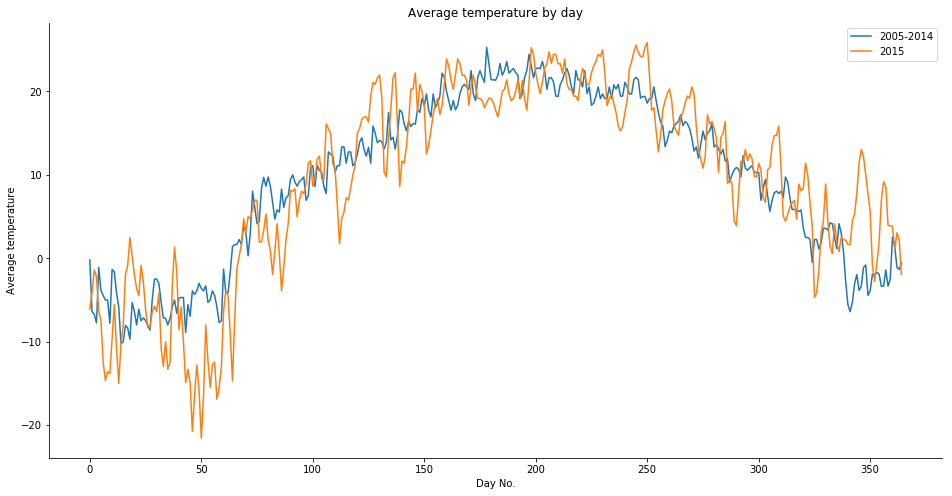

In [194]:
plt.figure(figsize=(16,8))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(new_df['Avg 10 year'],'-',new_df['Avg 2015'],'-')
plt.xlabel('Day No.')
plt.ylabel('Average temperature')
plt.title('Average temperature by day')
plt.legend(['2005-2014','2015'])
plt.show()